## Random forest ##

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, root_mean_squared_error
DATA_PATH = Path("/Users/maximeducotterd/Desktop/DSAP_intercantonal_dynamics/data/databasecsv.csv")

def load_data(path=DATA_PATH):
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"Dataset not found at {path.resolve()}")
        
    df = pd.read_csv(path, sep=";")
    df.columns = df.columns.str.strip()
    return df

df = load_data()
print("Loaded dataset:", df.shape)
def prepare_dataframe(df: pd.DataFrame):

    # canton FE ids
    df["canton_id"] = df["canton"].astype("category").cat.codes
    
    # lag
    df["migration_lag1"] = df.groupby("canton_id")["migration_rate"].shift(1)

    # canton fixed effects (one-hot)
    FE = pd.get_dummies(df["canton_id"], prefix="FE", drop_first=True)
    df = pd.concat([df, FE], axis=1)

    # feature list
    feature_cols = [
        "log_rent_avg",
        "log_avg_income",
        "log_unemployment",
        "log_schockexposure",
        "CLUSTER0",
        "CLUSTER1",
        "CLUSTER2",
        "migration_lag1",
    ]
    target_col = "migration_rate"

    # required columns
    cols_needed = feature_cols + [target_col]
    missing = [c for c in cols_needed if c not in df.columns]

    if missing:
        raise KeyError(
            f"Missing required columns: {missing}\n"
            f"Columns available: {list(df.columns)}"
        )

    # drop NA
    df = df.dropna(subset=cols_needed).copy()

    # numeric conversion
    df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors="coerce").values
    df[target_col] = pd.to_numeric(df[target_col], errors="coerce").values

    if df[feature_cols].isna().any().any() or df[target_col].isna().any():
        raise ValueError("NaN values detected after conversion.")

    return df, feature_cols, target_col

df_model, feature_cols, target_col = prepare_dataframe(df)
print("After cleaning:", df_model.shape)
def time_split(df: pd.DataFrame, feature_cols, target_col):

    df = df.sort_values("year").reset_index(drop=True)

    years = df["year"].unique()
    cut = int(0.8 * len(years))

    train_years = set(years[:cut])
    test_years  = set(years[cut:])

    X_train = df.loc[df["year"].isin(train_years), feature_cols].to_numpy()
    y_train = df.loc[df["year"].isin(train_years), target_col].to_numpy()

    X_test  = df.loc[df["year"].isin(test_years), feature_cols].to_numpy()
    y_test  = df.loc[df["year"].isin(test_years),  target_col].to_numpy()

    print("Train shape:", X_train.shape)
    print("Test shape :", X_test.shape)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = time_split(df_model, feature_cols, target_col)
def run_random_forest(X_train, y_train, X_test, y_test):

    rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=6,
        min_samples_leaf=5,
        max_features="sqrt",
        random_state=0,
        n_jobs=-1
    )

    # training
    rf.fit(X_train, y_train)
    y_train_pred = rf.predict(X_train)
    r2_train = r2_score(y_train, y_train_pred)

    # test prediction
    y_pred = rf.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return rf, y_pred, r2, rmse, r2_train

rf, y_pred, r2, rmse, r2_train = run_random_forest(X_train, y_train, X_test, y_test)

print("\n=== RANDOM FOREST RESULTS ===")
print(f"Train R² : {r2_train:.4f}")
print(f"Test  R² : {r2:.4f}")
print(f"Test RMSE: {rmse:.4f}")
def get_feature_importance(rf, feature_cols):
    importances = rf.feature_importances_
    feat_imp = sorted(zip(feature_cols, importances), key=lambda x: x[1], reverse=True)
    return feat_imp

feat_imp = get_feature_importance(rf, feature_cols)

print("\n=== FEATURE IMPORTANCES ===")
for name, imp in feat_imp:
    print(f"{name:25s} -> {imp:.4f}")


Loaded dataset: (285, 38)
After cleaning: (234, 66)
Train shape: (182, 8)
Test shape : (52, 8)

=== RANDOM FOREST RESULTS ===
Train R² : 0.7360
Test  R² : 0.5595
Test RMSE: 0.2153

=== FEATURE IMPORTANCES ===
migration_lag1            -> 0.4607
log_unemployment          -> 0.1719
log_rent_avg              -> 0.1143
log_avg_income            -> 0.1062
log_schockexposure        -> 0.0844
CLUSTER2                  -> 0.0369
CLUSTER1                  -> 0.0200
CLUSTER0                  -> 0.0055


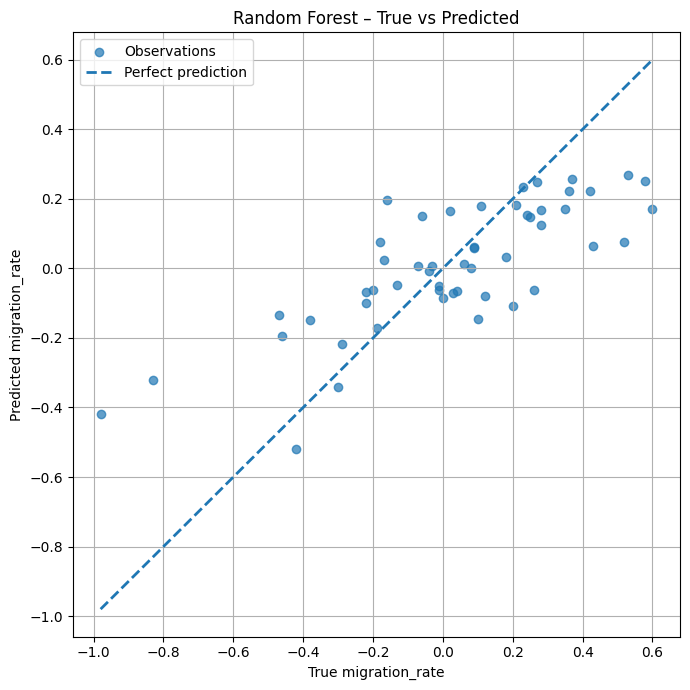

In [6]:
from pathlib import Path
import sys

ROOT = Path("/Users/maximeducotterd/Desktop/DSAP_intercantonal_dynamics")
sys.path.append(str(ROOT))

from src.ML.randomforest.randomforest import (
    load_data, prepare_dataframe, time_split, run_random_forest
)

from src.ML.randomforest.plotrandomforest import plot_true_vs_pred_rf


df = load_data()
df_model, feature_cols, target_col = prepare_dataframe(df)
X_train, X_test, y_train, y_test = time_split(df_model, feature_cols, target_col)
rf, y_pred, r2, rmse, r2_train = run_random_forest(X_train, y_train, X_test, y_test)



plot_true_vs_pred_rf(y_test, y_pred)
